<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/S6/blob/master/step%20of%205%20images%2C%20without%20L1%20L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [14]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:

import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 
        

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8


        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 



    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [16]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 10, 10]             576
             ReLU-11            [-1, 8, 10, 10]               0
      BatchNorm2d-12            [-1, 8, 10, 10]              16
          Dropout-13            [-1, 8, 10, 10]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [18]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.95)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10797706246376038 Batch_id=468 Accuracy=93.36: 100%|██████████| 469/469 [00:15<00:00, 31.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9863/10000 (98.63%)

EPOCH: 1


Loss=0.08938148617744446 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9896/10000 (98.96%)

EPOCH: 2


Loss=0.03496478125452995 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:14<00:00, 32.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.007401044014841318 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9889/10000 (98.89%)

EPOCH: 4


Loss=0.05777743086218834 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:15<00:00, 31.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.09137191623449326 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 29.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.011185596697032452 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 31.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.02350498177111149 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.11965090781450272 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.03880922496318817 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 30.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.029588088393211365 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.04384505748748779 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 30.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9944/10000 (99.44%)

EPOCH: 12


Loss=0.03188374638557434 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


Loss=0.03428513929247856 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:15<00:00, 30.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.07894543558359146 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 30.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9942/10000 (99.42%)

EPOCH: 15


Loss=0.03581351041793823 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9944/10000 (99.44%)

EPOCH: 16


Loss=0.005243962164968252 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 30.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.02181745134294033 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 31.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.015955358743667603 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 30.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.019198333844542503 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 30.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9947/10000 (99.47%)

EPOCH: 20


Loss=0.09622611850500107 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9950/10000 (99.50%)

EPOCH: 21


Loss=0.024355808272957802 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 30.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9949/10000 (99.49%)

EPOCH: 22


Loss=0.027426213026046753 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9933/10000 (99.33%)

EPOCH: 23


Loss=0.016801750287413597 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

EPOCH: 24


Loss=0.045632075518369675 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:15<00:00, 31.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9953/10000 (99.53%)

EPOCH: 25


Loss=0.0015434721717610955 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 30.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9950/10000 (99.50%)

EPOCH: 26


Loss=0.04503098130226135 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9945/10000 (99.45%)

EPOCH: 27


Loss=0.0035030145663768053 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9948/10000 (99.48%)

EPOCH: 28


Loss=0.06495865434408188 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9941/10000 (99.41%)

EPOCH: 29


Loss=0.02941671572625637 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9953/10000 (99.53%)

EPOCH: 30


Loss=0.0036501933354884386 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9945/10000 (99.45%)

EPOCH: 31


Loss=0.028064170852303505 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 33.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9952/10000 (99.52%)

EPOCH: 32


Loss=0.016983896493911743 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9939/10000 (99.39%)

EPOCH: 33


Loss=0.0038209259510040283 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 37.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9947/10000 (99.47%)

EPOCH: 34


Loss=0.020991867408156395 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 31.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9950/10000 (99.50%)

EPOCH: 35


Loss=0.030817925930023193 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 37.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9942/10000 (99.42%)

EPOCH: 36


Loss=0.009363651275634766 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9942/10000 (99.42%)

EPOCH: 37


Loss=0.07663309574127197 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9949/10000 (99.49%)

EPOCH: 38


Loss=0.10647580027580261 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 31.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

EPOCH: 39


Loss=0.008686681278049946 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]



Test set: Average loss: 0.0170, Accuracy: 9944/10000 (99.44%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

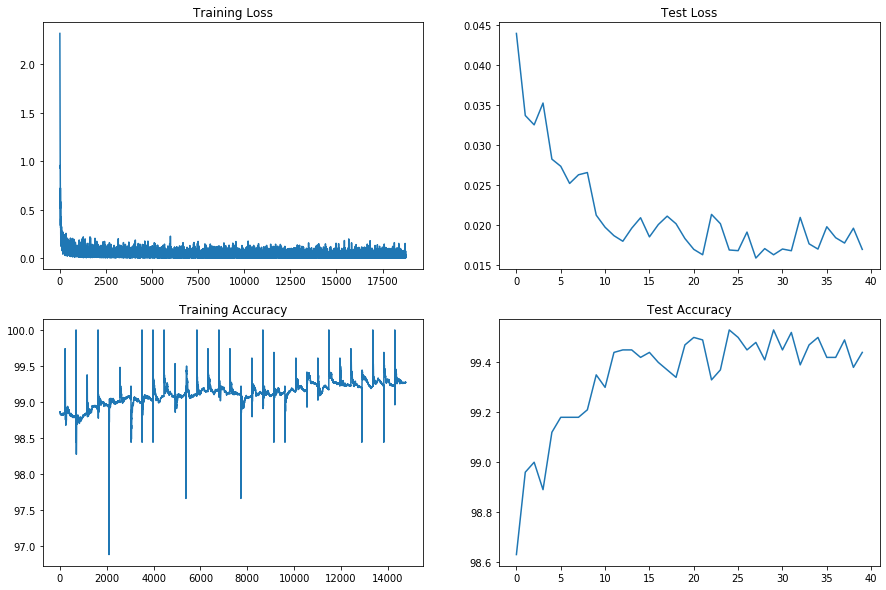

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

batchmates Mounika, Meenakshi, Vivek

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


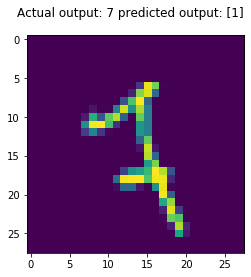

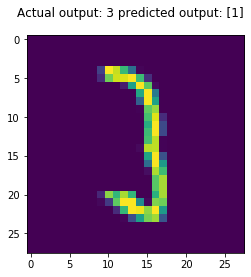

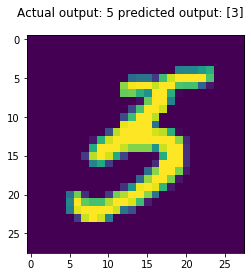

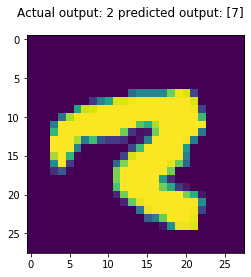

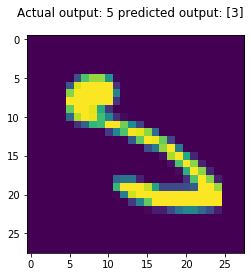

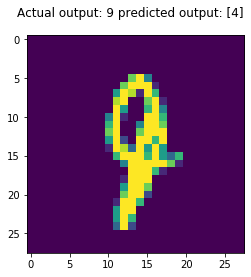

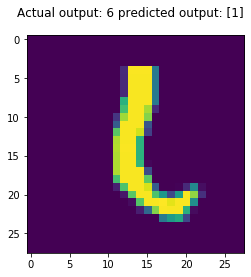

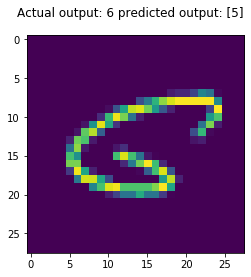

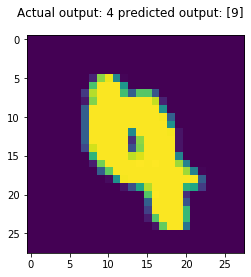

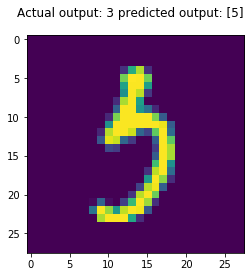

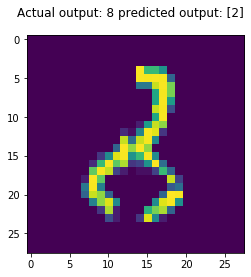

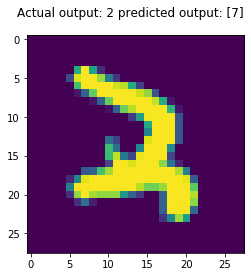

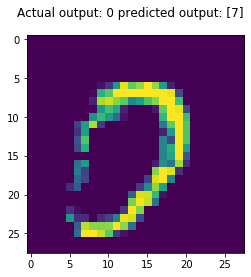

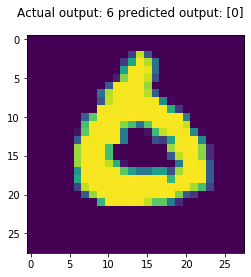

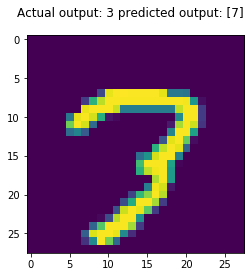

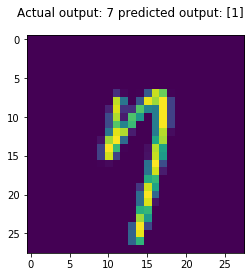

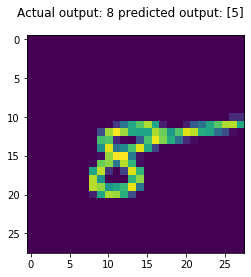

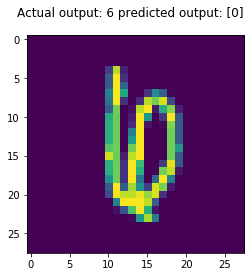

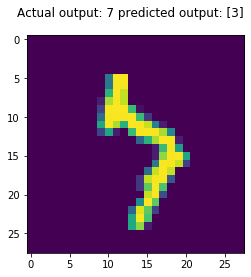

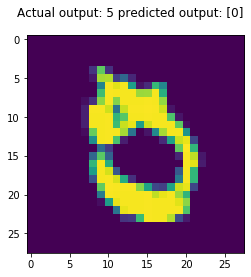

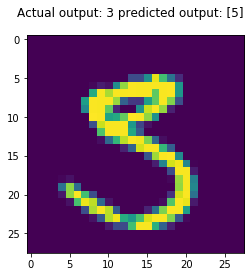

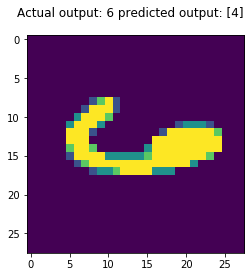

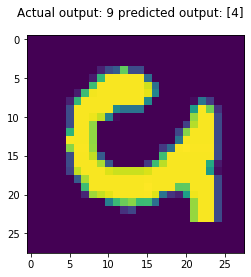

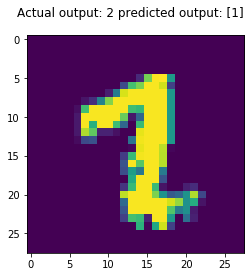

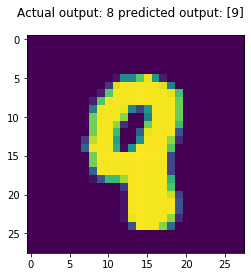

In [20]:

import numpy as np
import matplotlib.pyplot as plt

with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim= True)
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count==25:
                break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " predicted output: " + str(predx[i]))

                count = count+1